In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm

import sys
sys.path.append('D:\diplom_2\my_test')
import my_funcs as mf


import my_advection_funcs as maf

## STENCIL-NET

In [2]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from stencilnet import MLPConv, forward_rk3_error, backward_rk3_error#,backward_rk3_tvd_error,forward_rk3_tvd_error
# from stencilnet import forward_rk1_error,backward_rk1_error
from utils import load_simulation_model

##### 0. Mesh Params

In [3]:
generate_flg=True # True - генерация, False - чтение уже сгенерированных
# generate_flg=False

n=81 #число узлов
L=1 # длина расчт области
T=.9 #конечное время
kurant=1

h=L/(n-1)
b=(n-1)*0.1*L #width % of L (длина участка с v=1, составляет 10% от расчт области)
v=[1 if i in range(1,int(b)+1) else 0 for i in range(0,n) ]
print('Доля единиц:',np.round(100*v.count(1)/len(v),3))

Доля единиц: 9.877


##### 1. Study params

In [4]:
main_params=pd.read_excel('init_params.xlsx',dtype={'has_backward':bool})
main_params=main_params.set_index('param')
display(main_params)

,value
param,
seed,1
method,RK3
decay_const,0.9
train_split,0.7
m,4
epochs,50
l_wd,0.0
fs,7
neurons,64


In [5]:
#------------------------MAIN PARAMS-----------------------------
# size of filter to be applied
fs = int(main_params.loc['fs'])

# number of timesteps to be predicted during training 
m = int(main_params.loc['m'])

# decaying weights
decay_const = float(main_params.loc['decay_const'])

# epoch_number
epochs=int(main_params.loc['epochs'])

#random_seed
seed = int(main_params.loc['seed'])

#coef для loss функции
l_wd= float(main_params.loc['l_wd'])

# 'RK3' for runge-kutta solver and 'E1' for euler solver
method=str(main_params.loc['method'].values[0]) 

#neurons num in MLPConv
neurons=int(main_params.loc['neurons'])

#learning_rate
lr=float(main_params.loc['lr'])

#train_size
train_split=float(main_params.loc['train_split'])

# on/off bwd
has_backward=eval(main_params.loc['has_backward'].values[0])

#hidden_layers_num
hidden_layers_num=int(main_params.loc['hidden_layers_num'])

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#optuna n_trials
N_TRIALS=int(main_params.loc['N_TRIALS'])

##### 2. Generate data

In [6]:
CUSTOM_TAU=np.round(1/(n-1)-1/(n-1)/10,100)
# CUSTOM_TAU=kurant*h**2
print(CUSTOM_TAU)
v_fact,x_lst,tau,time_lst=maf.generate_data(generate_flg,v,T,L,1,h,n,CUSTOM_TAU=CUSTOM_TAU,save_flg=True)

0.011250000000000001
Генерация данных


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 1537.93it/s]

80 81
81 80


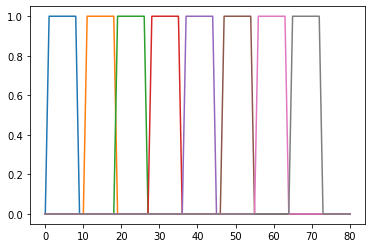

In [7]:
for j in range(0,len(v_fact[0,:]),10):
# for j in range(0,2,1):
    plt.plot(v_fact[:,j])

In [8]:
print('h',h,h**2)
print('tau',tau)
assert tau/h<=1,'не выполнено ограничение на число Куранта'

h 0.0125 0.00015625000000000003
tau 0.011250000000000001


##### 3.Subsample Data

In [9]:
t_factor = 10  # time subsample factor 
s_factor = 4   # space subsample factor
Tsim=len(v_fact[0])
dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
Ltc,v_coarse_train,v_coarse_test=mf.subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=0.7)

full_sample (21, 8)
train (21, 5)
test (21, 3)


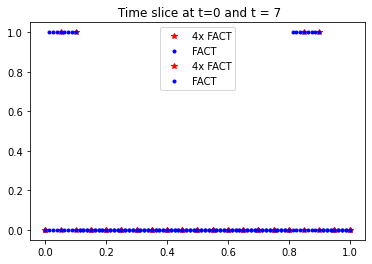

In [10]:
plt.figure()
time=0 #first time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.',color='blue',label='FACT')
time=v_coarse.shape[1]-1 #last time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.',color='blue',label='FACT')
plt.legend()
plt.title(" Time slice at t=0 and t = " + str(time))
plt.show()

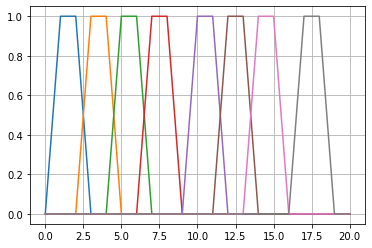

In [11]:
for j in range(0,len(v_coarse[0,:]),1):
    plt.plot(v_coarse[:,j])
plt.grid()
plt.show()

##### 4. Trainig model

In [12]:
import optuna

In [13]:
def objective_mplconv(trial):
    my_doc_params={
    'fs' : trial.suggest_categorical('fs',[1,3,5,9]),   
    'neurons' : trial.suggest_categorical('neurons',[16,32,64]) ,
    'hidden_layers_num': trial.suggest_categorical('hidden_layers_num',[0,1,2,3,4]),
    'lr': trial.suggest_categorical('lr',[1e-02,1e-03]),
    'm' : trial.suggest_categorical('m',[2,4]) ,  
    'has_backward' : trial.suggest_categorical('has_backward',[False])   
    }
    
    metric=mf.train_net(mf.MLPConv,v_coarse_train,mf.epochs,dtc,
                        **my_doc_params)[2]
    return metric

In [14]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_mplconv, n_trials=N_TRIALS)

[I 2024-10-28 21:38:31,911] A new study created in memory with name: no-name-5fee8b27-ad15-464b-9f31-f446b4c7ffd0


input 5 output 32
input 32 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 3393


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.41it/s, loss=0.289]
[I 2024-10-28 21:38:34,111] Trial 0 finished with value: 0.2894659638404846 and parameters: {'fs': 5, 'neurons': 32, 'hidden_layers_num': 4, 'lr': 0.001, 'm': 4, 'has_backward': False}. Best is trial 0 with value: 0.2894659638404846.


input 1 output 32
input 32 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 3265


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.46it/s, loss=0.267]
[I 2024-10-28 21:38:35,439] Trial 1 finished with value: 0.26693195104599 and parameters: {'fs': 1, 'neurons': 32, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 4, 'has_backward': False}. Best is trial 1 with value: 0.26693195104599.


input 1 output 32
input 32 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 3265


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.82it/s, loss=0.168]
[I 2024-10-28 21:38:36,667] Trial 2 finished with value: 0.16809365153312683 and parameters: {'fs': 1, 'neurons': 32, 'hidden_layers_num': 4, 'lr': 0.001, 'm': 2, 'has_backward': False}. Best is trial 2 with value: 0.16809365153312683.


input 9 output 64
input 64 output 64
input 64 output 64
input 64 output 64
input 64 output 1
#parameters: 13185


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.25it/s, loss=0.102]
[I 2024-10-28 21:38:38,354] Trial 3 finished with value: 0.10177072137594223 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 4, 'lr': 0.001, 'm': 2, 'has_backward': False}. Best is trial 3 with value: 0.10177072137594223.


input 3 output 1
#parameters: 4


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.02it/s, loss=0.338]
[I 2024-10-28 21:38:38,661] Trial 4 finished with value: 0.337593138217926 and parameters: {'fs': 3, 'neurons': 32, 'hidden_layers_num': 0, 'lr': 0.001, 'm': 2, 'has_backward': False}. Best is trial 3 with value: 0.10177072137594223.


input 5 output 64
input 64 output 64
input 64 output 1
#parameters: 4609


100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.53it/s, loss=0.29]
[I 2024-10-28 21:38:40,003] Trial 5 finished with value: 0.2898283302783966 and parameters: {'fs': 5, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.001, 'm': 4, 'has_backward': False}. Best is trial 3 with value: 0.10177072137594223.


input 5 output 1
#parameters: 6


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 88.15it/s, loss=0.373]
[I 2024-10-28 21:38:40,601] Trial 6 finished with value: 0.37333792448043823 and parameters: {'fs': 5, 'neurons': 16, 'hidden_layers_num': 0, 'lr': 0.001, 'm': 2, 'has_backward': False}. Best is trial 3 with value: 0.10177072137594223.


input 3 output 64
input 64 output 1
#parameters: 321


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.55it/s, loss=0.276]
[I 2024-10-28 21:38:41,531] Trial 7 finished with value: 0.2755308151245117 and parameters: {'fs': 3, 'neurons': 64, 'hidden_layers_num': 1, 'lr': 0.01, 'm': 4, 'has_backward': False}. Best is trial 3 with value: 0.10177072137594223.


input 9 output 32
input 32 output 32
input 32 output 1
#parameters: 1409


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.29it/s, loss=0.0291]
[I 2024-10-28 21:38:42,696] Trial 8 finished with value: 0.02907261997461319 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 64
input 64 output 64
input 64 output 64
input 64 output 1
#parameters: 9025


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.64it/s, loss=0.114]
[I 2024-10-28 21:38:44,023] Trial 9 finished with value: 0.11404933035373688 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 3, 'lr': 0.001, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 16
input 16 output 16
input 16 output 1
#parameters: 449


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 65.12it/s, loss=0.0647]
[I 2024-10-28 21:38:44,821] Trial 10 finished with value: 0.06468140333890915 and parameters: {'fs': 9, 'neurons': 16, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 16
input 16 output 16
input 16 output 1
#parameters: 449


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.52it/s, loss=0.0647]
[I 2024-10-28 21:38:45,691] Trial 11 finished with value: 0.06468140333890915 and parameters: {'fs': 9, 'neurons': 16, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 16
input 16 output 16
input 16 output 1
#parameters: 449


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.53it/s, loss=0.0647]
[I 2024-10-28 21:38:46,561] Trial 12 finished with value: 0.06468140333890915 and parameters: {'fs': 9, 'neurons': 16, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 16
input 16 output 16
input 16 output 1
#parameters: 449


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.47it/s, loss=0.0647]
[I 2024-10-28 21:38:47,448] Trial 13 finished with value: 0.06468140333890915 and parameters: {'fs': 9, 'neurons': 16, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 1
#parameters: 1409


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 76.89it/s, loss=0.0291]
[I 2024-10-28 21:38:48,121] Trial 14 finished with value: 0.02907261997461319 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 2465


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.32it/s, loss=0.094]
[I 2024-10-28 21:38:48,771] Trial 15 finished with value: 0.09402833133935928 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 3, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 1
#parameters: 353


100%|████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 124.98it/s, loss=0.0949]
[I 2024-10-28 21:38:49,191] Trial 16 finished with value: 0.09490230679512024 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 1, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 1 output 32
input 32 output 32
input 32 output 1
#parameters: 1153


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 121.95it/s, loss=0.15]
[I 2024-10-28 21:38:49,621] Trial 17 finished with value: 0.14966164529323578 and parameters: {'fs': 1, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 3 output 32
input 32 output 32
input 32 output 1
#parameters: 1217


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.24it/s, loss=0.267]
[I 2024-10-28 21:38:50,461] Trial 18 finished with value: 0.26655879616737366 and parameters: {'fs': 3, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 4, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 1
#parameters: 1409


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.09it/s, loss=0.0291]
[I 2024-10-28 21:38:51,661] Trial 19 finished with value: 0.02907261997461319 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 2465


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.87it/s, loss=0.094]
[I 2024-10-28 21:38:53,021] Trial 20 finished with value: 0.09402833133935928 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 3, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 1
#parameters: 1409


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 69.44it/s, loss=0.0291]
[I 2024-10-28 21:38:53,791] Trial 21 finished with value: 0.02907261997461319 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 1
#parameters: 1409


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 90.40it/s, loss=0.0291]
[I 2024-10-28 21:38:54,354] Trial 22 finished with value: 0.02907261997461319 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 1
#parameters: 1409


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.86it/s, loss=0.0291]
[I 2024-10-28 21:38:55,420] Trial 23 finished with value: 0.02907261997461319 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 1
#parameters: 353


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 61.70it/s, loss=0.0949]
[I 2024-10-28 21:38:56,271] Trial 24 finished with value: 0.09490230679512024 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 1, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 1
#parameters: 10


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.38it/s, loss=0.238]
[I 2024-10-28 21:38:56,931] Trial 25 finished with value: 0.23803849518299103 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 0, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 1 output 32
input 32 output 32
input 32 output 1
#parameters: 1153


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.19it/s, loss=0.269]
[I 2024-10-28 21:38:57,901] Trial 26 finished with value: 0.2693721354007721 and parameters: {'fs': 1, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 4, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 3 output 32
input 32 output 32
input 32 output 1
#parameters: 1217


100%|████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 114.96it/s, loss=0.0491]
[I 2024-10-28 21:38:58,357] Trial 27 finished with value: 0.049145929515361786 and parameters: {'fs': 3, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 5 output 64
input 64 output 64
input 64 output 1
#parameters: 4609


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.03it/s, loss=0.0746]
[I 2024-10-28 21:38:59,427] Trial 28 finished with value: 0.07455381006002426 and parameters: {'fs': 5, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 5 output 32
input 32 output 32
input 32 output 1
#parameters: 1281


100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.70it/s, loss=0.17]
[I 2024-10-28 21:39:00,711] Trial 29 finished with value: 0.17039437592029572 and parameters: {'fs': 5, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 4, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 1
#parameters: 353


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.70it/s, loss=0.0949]
[I 2024-10-28 21:39:01,491] Trial 30 finished with value: 0.09490230679512024 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 1, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 1
#parameters: 1409


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.40it/s, loss=0.0291]
[I 2024-10-28 21:39:02,571] Trial 31 finished with value: 0.02907261997461319 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 1
#parameters: 1409


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 90.97it/s, loss=0.0291]
[I 2024-10-28 21:39:03,146] Trial 32 finished with value: 0.02907261997461319 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 3521


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.78it/s, loss=0.0518]
[I 2024-10-28 21:39:04,151] Trial 33 finished with value: 0.05184207111597061 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 1 output 32
input 32 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 3265


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.49it/s, loss=0.149]
[I 2024-10-28 21:39:05,351] Trial 34 finished with value: 0.14878717064857483 and parameters: {'fs': 1, 'neurons': 32, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 32
input 32 output 32
input 32 output 1
#parameters: 1409


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.74it/s, loss=0.184]
[I 2024-10-28 21:39:06,551] Trial 35 finished with value: 0.18377414345741272 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.001, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 1
#parameters: 10


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.95it/s, loss=0.407]
[I 2024-10-28 21:39:07,311] Trial 36 finished with value: 0.40713122487068176 and parameters: {'fs': 9, 'neurons': 32, 'hidden_layers_num': 0, 'lr': 0.01, 'm': 4, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 1 output 32
input 32 output 32
input 32 output 1
#parameters: 1153


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 119.39it/s, loss=0.235]
[I 2024-10-28 21:39:07,741] Trial 37 finished with value: 0.23544102907180786 and parameters: {'fs': 1, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.001, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 3 output 64
input 64 output 64
input 64 output 64
input 64 output 64
input 64 output 1
#parameters: 12801


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.42it/s, loss=0.043]
[I 2024-10-28 21:39:09,538] Trial 38 finished with value: 0.04301756992936134 and parameters: {'fs': 3, 'neurons': 64, 'hidden_layers_num': 4, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 5 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 2337


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.49it/s, loss=0.321]
[I 2024-10-28 21:39:10,980] Trial 39 finished with value: 0.3206630349159241 and parameters: {'fs': 5, 'neurons': 32, 'hidden_layers_num': 3, 'lr': 0.001, 'm': 4, 'has_backward': False}. Best is trial 8 with value: 0.02907261997461319.


input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.03it/s, loss=0.0245]
[I 2024-10-28 21:39:12,861] Trial 40 finished with value: 0.02453790046274662 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 40 with value: 0.02453790046274662.


input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.03it/s, loss=0.0245]
[I 2024-10-28 21:39:13,821] Trial 41 finished with value: 0.02453790046274662 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 40 with value: 0.02453790046274662.


input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.52it/s, loss=0.0245]
[I 2024-10-28 21:39:15,671] Trial 42 finished with value: 0.02453790046274662 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 40 with value: 0.02453790046274662.


input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.95it/s, loss=0.0245]
[I 2024-10-28 21:39:17,651] Trial 43 finished with value: 0.02453790046274662 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 40 with value: 0.02453790046274662.


input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.66it/s, loss=0.0245]
[I 2024-10-28 21:39:19,661] Trial 44 finished with value: 0.02453790046274662 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 40 with value: 0.02453790046274662.


input 9 output 1
#parameters: 10


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 74.11it/s, loss=0.281]
[I 2024-10-28 21:39:20,391] Trial 45 finished with value: 0.28070515394210815 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 0, 'lr': 0.001, 'm': 2, 'has_backward': False}. Best is trial 40 with value: 0.02453790046274662.


input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.38it/s, loss=0.0245]
[I 2024-10-28 21:39:22,401] Trial 46 finished with value: 0.02453790046274662 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 40 with value: 0.02453790046274662.


input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.29it/s, loss=0.0245]
[I 2024-10-28 21:39:24,441] Trial 47 finished with value: 0.02453790046274662 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 40 with value: 0.02453790046274662.


input 3 output 64
input 64 output 64
input 64 output 1
#parameters: 4481


100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.39it/s, loss=0.118]
[I 2024-10-28 21:39:26,104] Trial 48 finished with value: 0.11776267737150192 and parameters: {'fs': 3, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 40 with value: 0.02453790046274662.


input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.59it/s, loss=0.0245]
[I 2024-10-28 21:39:27,916] Trial 49 finished with value: 0.02453790046274662 and parameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 40 with value: 0.02453790046274662.


In [15]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_fs,params_has_backward,params_hidden_layers_num,params_lr,params_m,params_neurons,state
0,0,0.289466,2024-10-28 21:38:31.911424,2024-10-28 21:38:34.111711,0 days 00:00:02.200287,5,False,4,0.001,4,32,COMPLETE
1,1,0.266932,2024-10-28 21:38:34.115706,2024-10-28 21:38:35.439718,0 days 00:00:01.324012,1,False,4,0.010,4,32,COMPLETE
2,2,0.168094,2024-10-28 21:38:35.439718,2024-10-28 21:38:36.663282,0 days 00:00:01.223564,1,False,4,0.001,2,32,COMPLETE
3,3,0.101771,2024-10-28 21:38:36.667277,2024-10-28 21:38:38.354187,0 days 00:00:01.686910,9,False,4,0.001,2,64,COMPLETE
4,4,0.337593,2024-10-28 21:38:38.354187,2024-10-28 21:38:38.661294,0 days 00:00:00.307107,3,False,0,0.001,2,32,COMPLETE
5,5,0.289828,2024-10-28 21:38:38.661294,2024-10-28 21:38:40.003687,0 days 00:00:01.342393,5,False,2,0.001,4,64,COMPLETE
6,6,0.373338,2024-10-28 21:38:40.011773,2024-10-28 21:38:40.601237,0 days 00:00:00.589464,5,False,0,0.001,2,16,COMPLETE
7,7,0.275531,2024-10-28 21:38:40.601237,2024-10-28 21:38:41.531116,0 days 00:00:00.929879,3,False,1,0.010,4,64,COMPLETE
8,8,0.029073,2024-10-28 21:38:41.531116,2024-10-28 21:38:42.696236,0 days 00:00:01.165120,9,False,2,0.010,2,32,COMPLETE
9,9,0.114049,2024-10-28 21:38:42.701267,2024-10-28 21:38:44.023377,0 days 00:00:01.322110,9,False,3,0.001,2,64,COMPLETE


In [16]:
study.trials_dataframe()
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'fs': 9, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}
Best RMSE: 0.02453790046274662


In [17]:
my_doc_params=study.best_params
net,loss_lst,loss=mf.train_net(mf.MLPConv,v_coarse_train,mf.epochs,dtc,
                               **my_doc_params)

input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 52.65it/s, loss=0.0245]


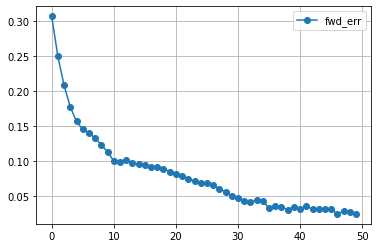

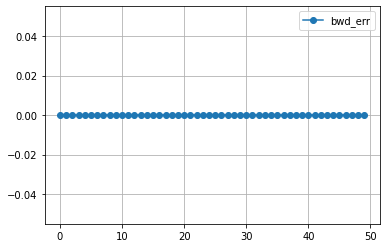

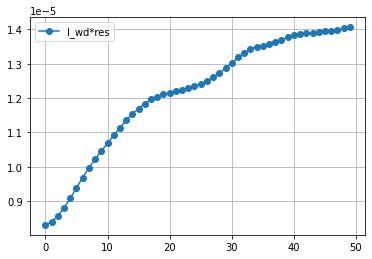

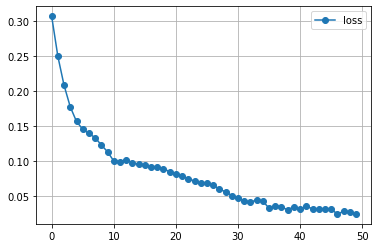

In [18]:
mf.plot_err_and_components_of_err(np.array(loss_lst))

##### 4/2. Re-fit on higher epoch_num 

In [19]:
high_epochs=500
my_doc_params=study.best_params
my_doc_params.update({'epoch':high_epochs})
display(mf.make_param_table(net,my_doc_params,tau,h,n,t_factor,s_factor))

,Parameter,Value
0,fs,9
1,neurons,64
2,hidden_layers_num,2
3,act_func,ELU(alpha=1.0)
4,epoch,500
5,lr,0.01
6,tau,0.01125
7,h,0.0125
8,n,81
9,decay_const,0.9


In [20]:
del my_doc_params['epoch']
net,loss_lst,loss=mf.train_net(mf.MLPConv,v_coarse_train,high_epochs,dtc,**my_doc_params)

input 9 output 64
input 64 output 64
input 64 output 1
#parameters: 4865


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 33.18it/s, loss=0.0178]


##### 5. save_model

In [26]:
str(list(my_doc_params))

"['fs', 'neurons', 'hidden_layers_num', 'lr', 'm', 'has_backward']"

In [27]:
# save model
torch.save(net, 'data/models/model_advection_n=' +str(n)+'_'+ str(list(my_doc_params.values()))+fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

In [28]:
# save study history
study.trials_dataframe().to_excel(fr'data/models/trials_dataframe_n=' +str(n)+'_'+ str(list(my_doc_params.values()))+'.xlsx',index=False)

In [29]:
# save hyperparams
my_doc_params['fs']=[my_doc_params['fs']]
pd.DataFrame.from_dict(my_doc_params,dtype=str)

,fs,neurons,hidden_layers_num,lr,m,has_backward
0,9,64,2,0.01,2,False


In [30]:
pd.DataFrame.from_dict(my_doc_params,dtype=str).to_excel(fr'data/models/best_params_n=' +str(n)+'_'+str(list(my_doc_params.values()))+'.xlsx',index=False)

##### 6. load_model

In [ ]:
# neurons = 64
# fs=7
# epochs=100
# m=4
# l_wd=0#1e-3
# seed=1
#method='E1'

# net = load_simulation_model(s_factor, t_factor, neurons, device)

# net=torch.load('./models/model_advection_n=' +str(n)+'_' + str(fs) + "_"+str(t_factor) +'L_' + str(neurons) + '_ep_' + str(epochs)  + '_' + "elu" + '_m' + str(m) + '_Lxc' +  str(s_factor) + "_Ltc" + str(t_factor) +  '_lwd' + str(l_wd) +fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

##### 7. Simulation

In [21]:
NN_sim,T_sim,x_sim=mf.make_simulation(net,v_coarse,L,Lxc,dtc)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 348.51it/s]


##### 8. view_results

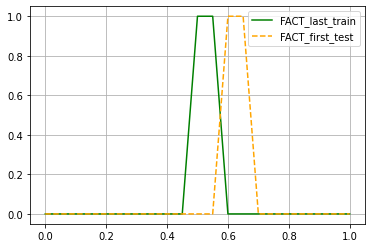

In [22]:
mf.view_train_test_graph(x_sim,v_coarse_train,v_coarse_test)

In [23]:
# # todo
# display(make_param_table(net,my_doc_params))

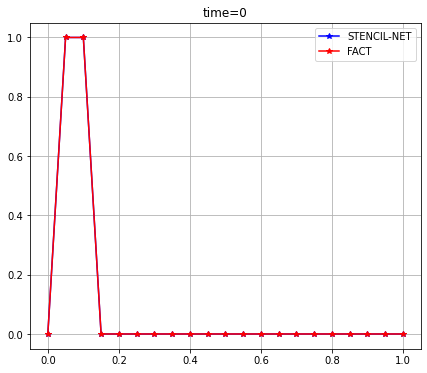

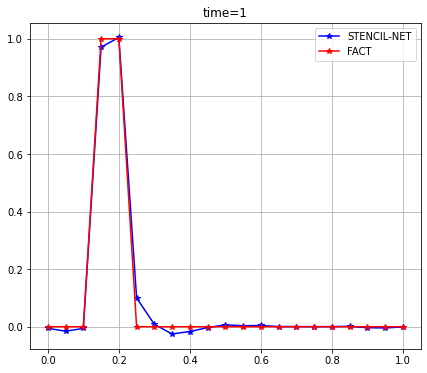

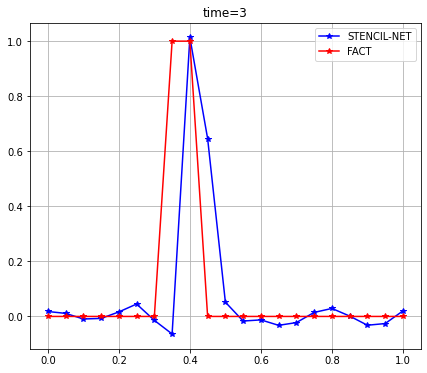

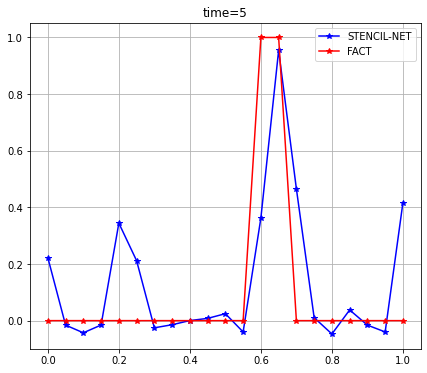

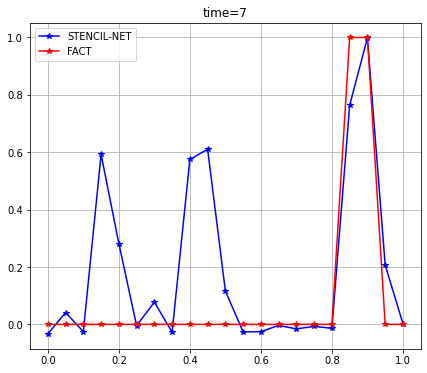

In [24]:
mf.view_results(T_sim,x_sim,NN_sim,v_coarse)

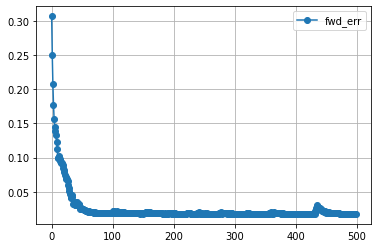

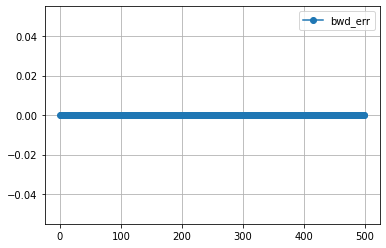

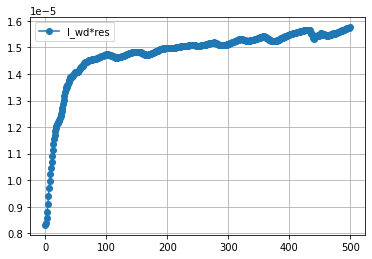

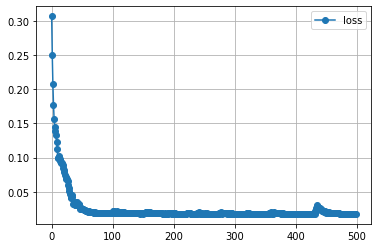

In [25]:
mf.plot_err_and_components_of_err(np.array(loss_lst))